<a href="https://colab.research.google.com/github/AmrMohamadSalah/Image-Segmentation/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Drive Connection

Mount Drive

In [ ]:
from google.colab import drive  
drive.mount('/content/gdrive')

Import Libraries

In [ ]:
import math
from PIL import Image
import numpy as np
import scipy.io
import glob
import matplotlib.pyplot as plt
import matplotlib.image as im
import random
import math
from sklearn.metrics import f1_score
from scipy.stats import entropy
from more_itertools import sort_together
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd

# Download the Dataset and Understand the Format

Images

In [ ]:
def LoadPictures(directory):
  images = []
  for path in sorted(glob.glob(directory)):
    image = Image.open(path)
    image = np.asarray(image)
    images.append(image)
  return np.array(images, dtype=object)

GroundTruth

In [ ]:
def LoadGroundTruth(directory):
  images = []
  for path in sorted(glob.glob(directory)):
    image = scipy.io.loadmat(path)
    images.append(image)
  return np.array(images)

Loading Images and GroundTruths

In [ ]:
images = LoadPictures("/content/gdrive/MyDrive/Assignment2/Dataset/BSR/BSDS500/data/images/test/*.jpg")
matFiles = LoadGroundTruth("/content/gdrive/MyDrive/Assignment2/Dataset/BSR/BSDS500/data/groundTruth/test/*.mat")

Save Groundtruth as Pictures

In [ ]:
def saveGroundtruth(matFiles):
      for i in range(len(matFiles)):
        for j in range(len(matFiles[i]['groundTruth'][0])):
            x = matFiles[i]['groundTruth'][0][j][0][0][0]
            im.imsave(f'/content/gdrive/MyDrive/Assignment2/BigPicture/GroundTruth/80_{j}_GT.png', x)

In [ ]:
file = scipy.io.loadmat('/content/gdrive/MyDrive/Assignment2/Dataset/BSR/BSDS500/data/groundTruth/5images/*.mat')
saveGroundtruth([file])

# Visualize the image and the ground truth segmentation

In [ ]:
def visualize(matFile):
  x = []
  for i in range(len(matFile['groundTruth'][0])):
    z = matFile['groundTruth'][0][i][0][0][0]
    x.append(np.array(z))
    plt.figure()
    plt.title(i)
    plt.show()
  return x

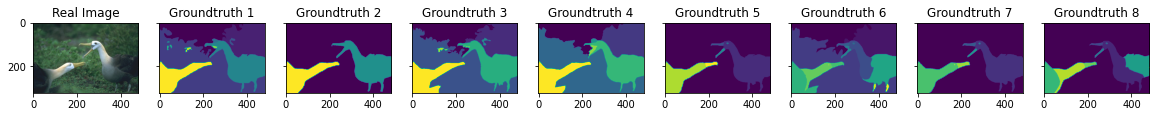

In [ ]:
vis = visualize(matFiles[8])
f, axarr = plt.subplots(1, len(vis)+1, sharey=True)
f.set_figheight(20)
f.set_figwidth(20)
axarr[0].imshow(images[8])
axarr[0].set_title('Real Image')
for i in range(len(axarr)-1):
    axarr[i+1].imshow(vis[i])
    axarr[i+1].set_title(f'Groundtruth {i+1}')

# K-Means

K-Means Algorithm

In [ ]:
def KMeans(image, K):
    size = len(image)
    for y in range(size):
        for k in K:
            shape = image[y].shape
            image_temp = image[y].reshape(shape[0] * shape[1], shape[2])
            size = len(image_temp)
            centroid = []
            for i in range(k):
                centroid.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])
            Distance = np.zeros((size, k))
            label = np.zeros(size, dtype=int)
            while True:
                for i in range(size):
                    for j in range(k):
                        Distance[i][j] = np.linalg.norm(centroid[j] - image_temp[i])
                for i in range(size):
                    label[i] = np.argmin(Distance[i])
                cluster = []
                for i in range(k):
                    cluster.append([])
                for i in range(size):
                    cluster[label[i]].append(image_temp[i])
                oldCentroid = centroid.copy()
                for i in range(k):
                    if not len(cluster[i]):
                        centroid[i] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
                    else:
                        centroid[i] = np.mean(cluster[i], axis=0)
                Difference = np.zeros(k)
                for i in range(k):
                    Difference[i] = np.linalg.norm(np.array(centroid[i]) - np.array(oldCentroid[i]))
                if np.mean(Difference) <= 0.5:
                    break
            # segmentation = []
            # for i in range(size):
            #     segmentation.append(np.array(centroid[label[i]], dtype=int))
            segmentation = label.reshape(shape[0], shape[1])
            # plt.figure()
            # plt.title(f'{k}-Means')
            # plt.imshow(segmentation)
            # plt.show()
            im.imsave(f'/content/gdrive/MyDrive/Assignment2/K_Means/{y}_{k}_Means.png', segmentation)
            print(f"Done Picture Number {y} ---> {k}-Means")

K-Means Clustering

In [ ]:
K = [3, 5, 7, 9, 11]
KMeans(images, K)

# Measures

F-Measure

In [ ]:
def F_Measure(Truth, Predicted):
    Contingency = contingency_matrix(Truth, Predicted)
    rows = len(Contingency)
    measures = []
    for i in range(rows):
        index = np.argmax(Contingency[i])
        Precision = Contingency[i][index] / np.sum(Contingency[i])
        Recall = Contingency[i][index] / np.sum(Contingency.transpose()[i])
        measures.append((2 * Precision * Recall) / (Precision + Recall))
    F = np.mean(measures)
    return F

Conditional Entropy

In [ ]:
def Conditional_Entropy(Truth, Predicted):
    Contingency = contingency_matrix(Truth, Predicted)
    rows = len(Contingency)
    conditional_entropy = []
    total = np.sum(Contingency)
    for i in range(rows):
        cluster_size = np.sum(Contingency[i])
        temp = 0
        for j in range(len(Contingency[i])):
            probability = Contingency[i][j] / cluster_size
            if probability == 0:
                continue
            temp -= probability * math.log2(probability)
        conditional_entropy.append(temp * (cluster_size / total))
    CE = np.sum(conditional_entropy)
    return CE

Generate Labels From Saved Pictures

In [ ]:
def getLabels(image):
    label = []
    test = [image[0][0].tolist()]
    h = 2
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(len(test)):
                if image[i][j].tolist() == test[k]:
                    label.append(k + 1)
            if not image[i][j].tolist() in test:
                test.append(image[i][j].tolist())
                label.append(h)
                h += 1
    return label

Reduce Clusters of GroundTruth

In [ ]:
def reduceClusters(gtlabels, names, k):
    gtlabels = gtlabels.copy()
    if len(names) >= k:
        clusters = []
        for i in range(k - 1):
            clusters.append(names[i])
        for i, n in enumerate(gtlabels):
            if n not in clusters:
                gtlabels[i] = names[k - 1]
    return gtlabels

Measures Generation

In [ ]:
def GenerateMeasures():
    K = [3, 5, 7, 9, 11]
    FM = []
    CE = []
    for i in range(50):
        FM_PIC = []
        CE_PIC = []
        for j in range(len(matFiles[i]['groundTruth'][0])):
            FM_GT = []
            CE_GT = []
            gtLabels = matFiles[i]['groundTruth'][0][j][0][0][0].copy()
            values, names = zip(
                *sorted(
                    zip(
                        np.unique(gtLabels, return_counts=True)[1],
                        np.unique(gtLabels, return_counts=True)[0]),
                    reverse=True)
            )
            values = list(values)
            names = list(names)
            gtLabels = gtLabels.ravel()
            for k in range(5):
                newGT = reduceClusters(gtLabels, names, K[k])
                image = Image.open(f'/content/gdrive/MyDrive/Assignment2/K_Means/{i}_{K[k]}_Means.png')
                image = np.asarray(image)
                imageLabels = getLabels(image)
                FM_GT.append(F_Measure(newGT, imageLabels))
                CE_GT.append(Conditional_Entropy(newGT, imageLabels))
            FM_PIC.append(FM_GT)
            CE_PIC.append(CE_GT)
        FM.append(FM_PIC)
        CE.append(CE_PIC)
    FM = np.array(FM, dtype=object)
    CE = np.array(CE, dtype=object)
    return FM, CE

Measures Calculation

In [ ]:
FM, CE = GenerateMeasures()

In [ ]:
print(FM)
print(CE)

[list([[0.8621474312972671, 0.5188874657105285, 0.5646021014330519, 0.5920953999931446, 0.562833434375851], [0.8610798127968039, 0.5337034475929612, 0.4335110846552098, 0.4147962728784324, 0.42524577121497725], [0.8174271886745164, 0.6355221175610705, 0.5220556658798914, 0.46598638327377895, 0.4782341399661642], [0.8548821003097085, 0.509767918886408, 0.44210375329186313, 0.3643326602694726, 0.30510017494835995], [0.8649932430075187, 0.6665569689967785, 0.49480746853881513, 0.41395835404610337, 0.35648950093726595]])
 list([[0.5589268968567432, 0.43774315196471675, 0.3190168638626018, 0.22078306185559268, 0.19995528513647576], [0.5482535910020768, 0.5158829819279445, 0.4214129366102631, 0.33543575942758314, 0.34559871128278946], [0.5600957854740812, 0.5917478359096141, 0.5454317550489298, 0.4187985552755631, 0.44603508406424597], [0.5528574819526794, 0.47120981626726505, 0.4347149888490627, 0.3331055742431581, 0.3546519956598356], [0.5995630494824755, 0.5229333972920233, 0.420453768955

Tabulate Measures

In [ ]:
K = [3, 5, 7, 9, 11]
testFM = []
testCE = []
for i in range(50):
  columns = ['F-Measures', 'Conditional Entropy']
  rows2 = []
  FMflat = [item for sublist in FM[i] for item in sublist]
  CEflat = [item for sublist in CE[i] for item in sublist]
  testFM.append(FMflat)
  testCE.append(CEflat)
  for j in range(len(FM[i])):
    for k in range(5):
      rows2.append(f'GT {j+1} K = {K[k]}')
  table = pd.DataFrame({'F-Measures': FMflat, 'Conditional Entropy': CEflat}, index=rows2)
  row = [np.average(FMflat), np.average(CEflat)]
  table.loc['Average'] = row
  print(f'\t\tImage Number {i+1}')
  print(table)
  print('---------------------------------------------')

		Image Number 1
             F-Measures  Conditional Entropy
GT 1 K = 3     0.862147             0.673751
GT 1 K = 5     0.518887             1.310092
GT 1 K = 7     0.564602             1.621248
GT 1 K = 9     0.592095             1.756188
GT 1 K = 11    0.562833             1.992448
GT 2 K = 3     0.861080             0.675423
GT 2 K = 5     0.533703             1.290213
GT 2 K = 7     0.433511             1.592688
GT 2 K = 9     0.414796             1.727421
GT 2 K = 11    0.425246             1.962426
GT 3 K = 3     0.817427             0.789888
GT 3 K = 5     0.635522             1.288531
GT 3 K = 7     0.522056             1.499148
GT 3 K = 9     0.465986             1.630107
GT 3 K = 11    0.478234             1.862350
GT 4 K = 3     0.854882             0.699394
GT 4 K = 5     0.509768             1.322014
GT 4 K = 7     0.442104             1.584412
GT 4 K = 9     0.364333             1.712734
GT 4 K = 11    0.305100             1.940940
GT 5 K = 3     0.864993             0.

Statistics

In [ ]:
  FMtotal = [item for sublist in testFM for item in sublist]
  CEtotal = [item for sublist in testCE for item in sublist]

  print(f'Average F-Measuer for dataset = {np.average(FMtotal)}')
  print(f'Average Conditional Entropy for dataset = {np.average(CEtotal)}')

Average F-Measuer for dataset = 0.42155272325494103
Average Conditional Entropy for dataset = 1.8928194780307972


Save Measures

In [ ]:
np.save("F_Measures.npy", FM)
np.save("Cond_Entropy.npy", CE)

Restore Measures

In [ ]:
FM_npy = np.load("F_Measures.npy",allow_pickle=True)

print("NumPy array: \n", FM_npy)
print("Shape: ", FM_npy.shape)
print("Data Type: ", FM_npy.dtype.name)

In [ ]:
CE_npy = np.load("Cond_Entropy.npy",allow_pickle=True)

print("NumPy array: \n", CE_npy)
print("Shape: ", CE_npy.shape)
print("Data Type: ", CE_npy.dtype.name)

# Big Picture

Comparing groundtruth and image Segmentation results using 5-means clustering

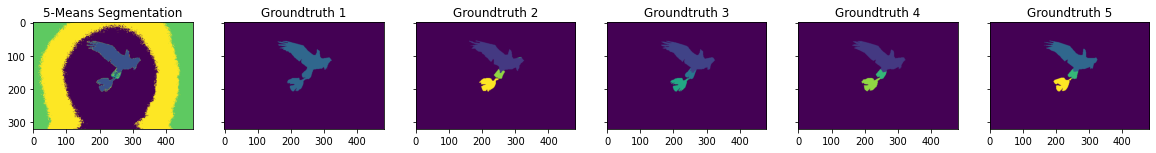

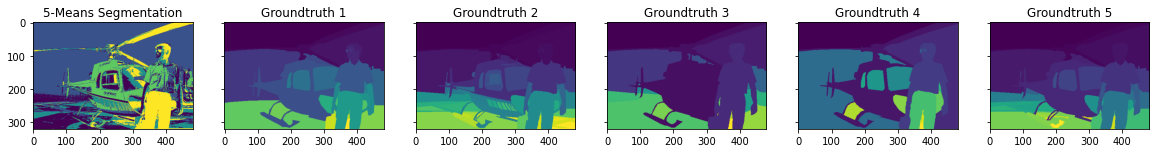

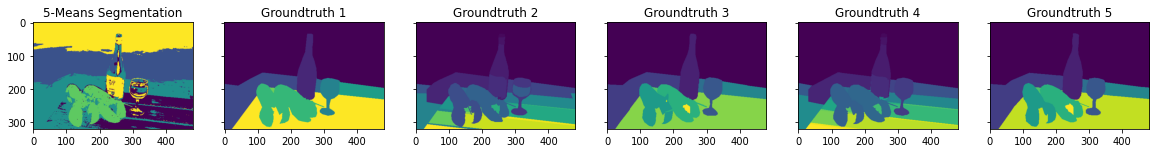

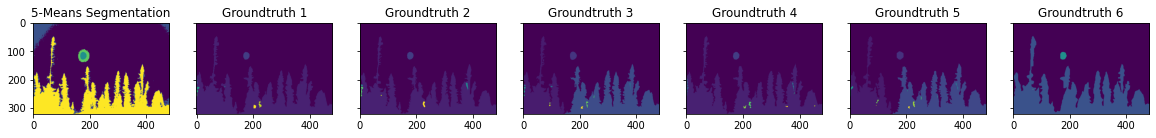

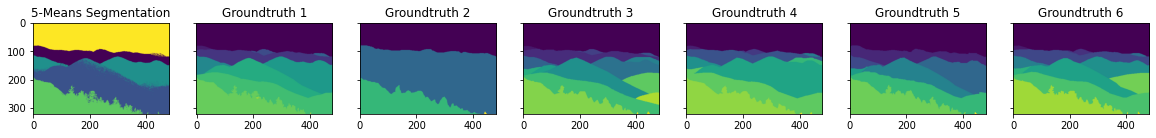

In [ ]:
for i in range(5):
    images_5 = Image.open(f'/content/gdrive/MyDrive/Assignment2/BigPicture/{i}_5_Means.png')
    images_5 = np.asarray(images_5)
    t = glob.glob(f'/content/gdrive/MyDrive/Assignment2/BigPicture/GroundTruth/{i}_*.png')
    groundTruth_5 = []
    for j in range(len(t)):
        groundTruth_5.append(Image.open(t[j]))
    f, axarr = plt.subplots(1, len(t)+1, sharey=True)
    f.set_figheight(20)
    f.set_figwidth(20)
    axarr[0].imshow(images_5)
    axarr[0].set_title('5-Means Segmentation')
    for k in range(len(axarr)-1):
        axarr[k+1].imshow(groundTruth_5[k])
        axarr[k+1].set_title(f'Groundtruth {k+1}')

# Spectral Clustering

Resize Pictures & Groundtruth


In [ ]:
def reSize():
    factor = 1
    for i in range(5):
        imageToResize = Image.open(f'/content/gdrive/MyDrive/Assignment2/Dataset/BSR/BSDS500/data/images/5images/{i}.jpg')
        dim1 = (round(imageToResize.width/factor), round(imageToResize.height/factor))
        imageToResize.thumbnail(dim1)
        imageToResize.save(f'/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/images/{i}.jpg')
        t = glob.glob(f'/content/gdrive/MyDrive/Assignment2/BigPicture/GroundTruth/{i}_*.png')
        for j in range(len(t)):
            gtToResize = Image.open(t[j])
            dim2 = (round(gtToResize.width/factor), round(gtToResize.height/factor))
            gtToResize.thumbnail(dim2)
            gtToResize.save(f'/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/groundTruth/{i}_{j}_GTResized.png')

In [ ]:
reSize()

K-Means for Normalized Cut Algorithm

In [ ]:
def KMean_NormalizedCut(K_EigenVectors, k):
    size = len(K_EigenVectors)
    centroid = []
    for i in range(k):
        centroid.append(K_EigenVectors[random.randint(0, size-1)].copy())
    Distance = np.zeros((size, k))
    label = np.zeros(size, dtype=int)
    while True:
        for i in range(size):
            for j in range(k):
                Distance[i][j] = np.linalg.norm(K_EigenVectors[i] - centroid[j])
        for i in range(size):
            label[i] = np.argmin(Distance[i])
        cluster = []
        for i in range(k):
            cluster.append([])
        for i in range(size):
            cluster[label[i]].append(K_EigenVectors[i])
        oldCentroid = centroid.copy()
        for i in range(k):
            if not len(cluster[i]):
                centroid[i] = K_EigenVectors[random.randint(0, size-1)].copy()
            else:
                centroid[i] = np.mean(cluster[i], axis=0)
        Difference = np.zeros(k)
        for i in range(k):
            Difference[i] = np.linalg.norm(oldCentroid[i] - centroid[i])
        if np.mean(Difference) <= 1:
            break
    return label

Normalized Cut - First Algorithm

In [ ]:
def normalizedCut(images, s):
    size = len(images)
    dimension = images[0].shape[0] * images[0].shape[1]
    distances = np.zeros((dimension, dimension))
    similarity = np.zeros((dimension, dimension), dtype=np.int8)
    degree = np.zeros((dimension, dimension), dtype=np.int8)
    for k in range(size):
        shape = images[k].shape
        images[k] = images[k].reshape(shape[0]*shape[1], shape[2])
        for i in range(dimension):
            for j in range(dimension):
                diff = images[k][i] - images[k][j]
                diff = np.array(diff)
                if np.all((diff == 0)):
                  distances[i][j] = 0
                else:   
                  distances[i][j] = math.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)
        for i in range(dimension):
            furthest = np.amax(distances[i])
            j = 0
            while j < s:
                index = np.argmin(distances[i])
                distances[i][index] = furthest + 1
                if index != i:
                    similarity[i][index] = 1
                    j += 1
        for i in range(dimension):
            degree[i][i] = np.sum(similarity[i])
        L = degree - similarity
        Dinv = np.linalg.inv(degree)
        La = np.dot(Dinv, L)
        eigenValues, eigenVectors = np.linalg.eigh(La)
        start = 0
        while eigenValues[start] <= 0:
            start += 1
        K_EigenVectors = eigenVectors[:, range(start, s + start)]
        for i in range(dimension):
            K_EigenVectors[i] = K_EigenVectors[i] / np.linalg.norm(K_EigenVectors[i])
        label = KMean_NormalizedCut(K_EigenVectors, s)
        # kmeans = KMeans(n_clusters=s, random_state=0).fit(K_EigenVectors)
        # label = kmeans.labels_
        label = label.reshape(shape[0], shape[1])
        im.imsave(f'/content/gdrive/MyDrive/Assignment2/BigPicture/NormalizedCut/{k}_{s}-NN.png', label)
        return K_EigenVectors, label

Runtime - EigenVectors contain nan values

In [ ]:
pictures = Image.open('/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/images/0.jpg')
picArray = np.asarray(pictures)
K_EigenVectors = normalizedCut([picArray], 5)

Normalized Cut - Second Algorithm

In [ ]:
def NormalizedCut_K_NN(image, k):
  shape = image.shape
  image = image.reshape(shape[0]*shape[1], shape[2])
  Similarity = kneighbors_graph(image, k)
  Similarity = Similarity.toarray()
  Degree = np.zeros(Similarity.shape)
  for i in range(len(Similarity)):
    Degree[i][i] = np.sum(Similarity[i])
  L = Degree - Similarity
  Dinv = Degree
  for i in range(len(Dinv)):
    Dinv[i][i] = 1/Dinv[i][i]
  La = np.dot(Dinv, L)
  eigenValues, eigenVectors = np.linalg.eigh(La)
  start = 0
  while eigenValues[start] <= 0:
    start += 1
  K_EigenVectors = eigenVectors[:, range(start, k + start)]
  for i in range(len(K_EigenVectors)):
    K_EigenVectors[i] = K_EigenVectors[i] / np.linalg.norm(K_EigenVectors[i])
  label = KMean_NormalizedCut(K_EigenVectors, k)
  # kmeans = KMeans(n_clusters=k, random_state=0).fit(K_EigenVectors)
  # label = kmeans.labels_
  label = label.reshape(shape[0], shape[1])
  im.imsave(f'/content/gdrive/MyDrive/Assignment2/BigPicture/NormalizedCut/{"trial"}_{k}-NN.png', label)
  return K_EigenVectors, label

In [ ]:
pictures = Image.open('/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/images/4.jpg')
picArray = np.asarray(pictures)

In [ ]:
S = NormalizedCut_K_NN(picArray, 5)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


Normalized Cut - Third Algorithm

In [ ]:
def NormalizedCut_K(image, k):
  shape = image.shape
  image = image.reshape(shape[0]*shape[1], shape[2])
  clustering = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', n_neighbors=5).fit_predict(np.copy(image))
  return clustering, shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expecte

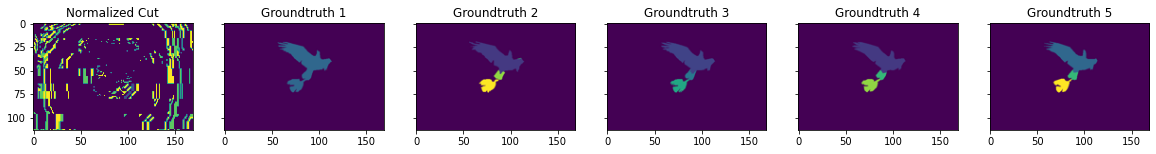

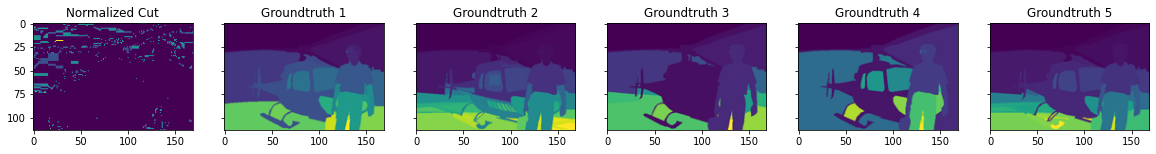

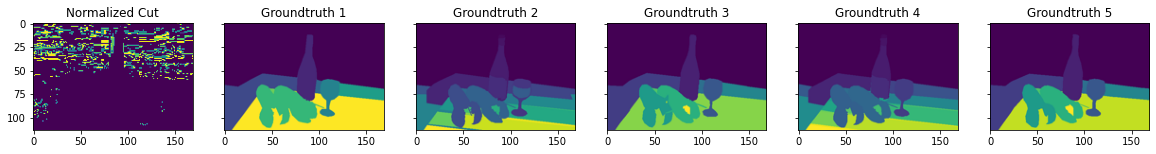

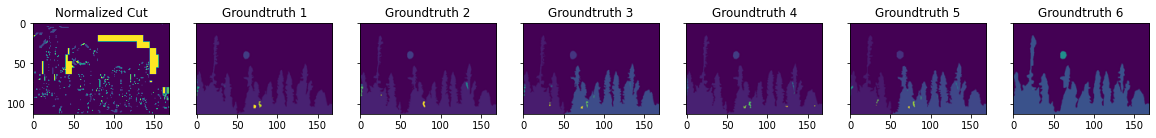

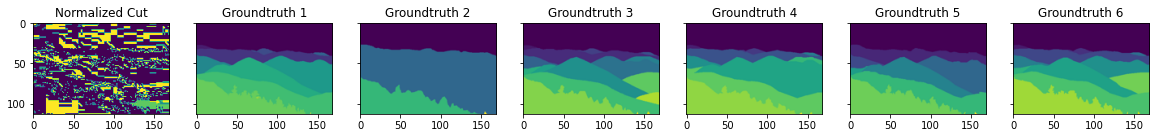

In [ ]:
for i in range(5):
    resizedImage = Image.open(f'/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/images/{i}.jpg')
    resizedImage = np.asarray(resizedImage)
    t = glob.glob(f'/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/groundTruth/{i}_*.png')
    groundTruth_5 = []
    for j in range(len(t)):
        groundTruth_5.append(Image.open(t[j]))
    nCutLabels, shape2 = NormalizedCut_K(resizedImage, 5)
    f, axarr = plt.subplots(1, len(t)+1, sharey=True)
    f.set_figheight(20)
    f.set_figwidth(20)
    axarr[0].imshow(nCutLabels.reshape(shape2[0],shape2[1]))
    axarr[0].set_title('Normalized Cut')
    for k in range(len(groundTruth_5)):
        axarr[k+1].imshow(groundTruth_5[k])
        axarr[k+1].set_title(f'Groundtruth {k+1}')

Normalized Cut vs K-Means

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expecte

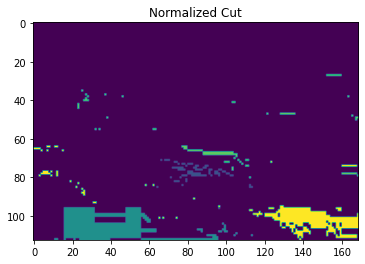

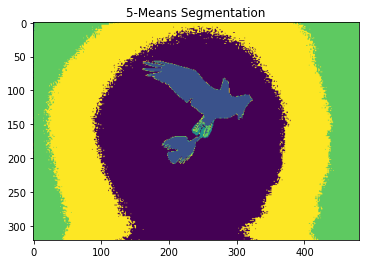

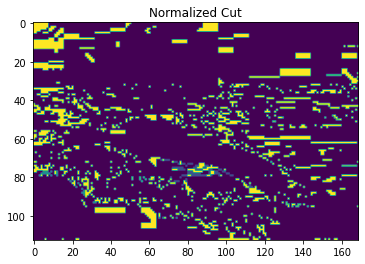

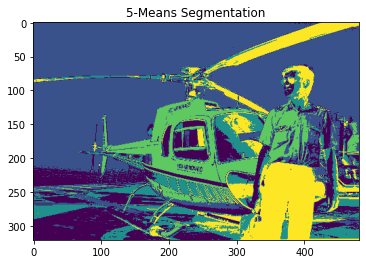

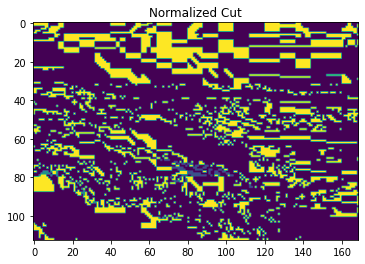

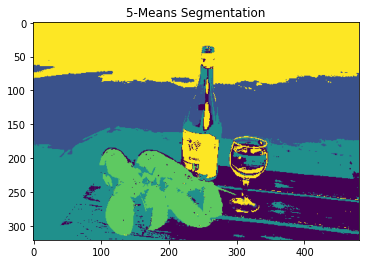

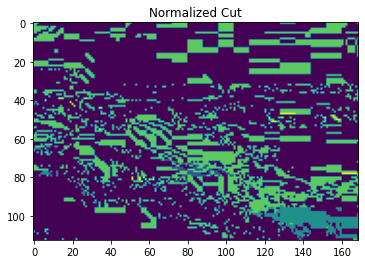

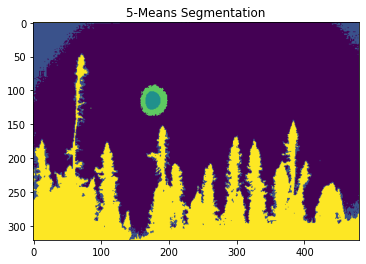

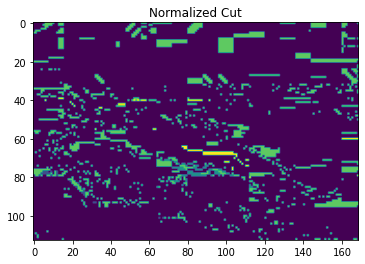

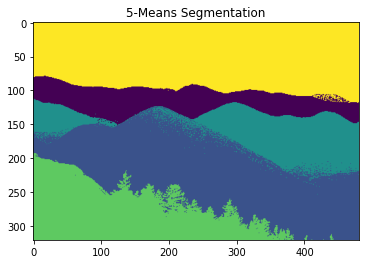

In [ ]:
for i in range(5):
    resizedImage2 = Image.open(f'/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/images/{i}.jpg')
    resizedImage2 = np.asarray(resizedImage)
    images_5 = Image.open(f'/content/gdrive/MyDrive/Assignment2/BigPicture/{i}_5_Means.png')
    images_5 = np.asarray(images_5)
    nCutLabels2, shape3 = NormalizedCut_K(resizedImage2, 5)
    # f, axarr = plt.subplots(1, 2, sharey=True)
    # f.set_figheight(12)
    # f.set_figwidth(12)
    plt.figure()
    plt.imshow(nCutLabels2.reshape(shape3[0],shape3[1]))
    plt.title('Normalized Cut')
    plt.figure()
    plt.imshow(images_5)
    plt.title('5-Means Segmentation')
    plt.show

# Spatial K-Means

Dimensionality Consideration

In [ ]:
def Dimensionalize(image):
  shape = image.shape
  image = image.tolist()
  for i in range(shape[0]):
    for j in range(shape[1]):
      image[i][j].append(i)
      image[i][j].append(j)
  return np.array(image)

Spatial K-Means Algorithm

In [ ]:
def Spatial_KMeans(image, K):
    size = len(image)
    for y in range(size):
        for k in K:
            shape = image[y].shape
            image_temp = Dimensionalize(image[y].copy()).reshape(shape[0] * shape[1], shape[2]+2)
            size = len(image_temp)
            centroid = []
            for i in range(k):
                centroid.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), random.randint(0, shape[0]-1), random.randint(0, shape[1]-1)])
            Distance = np.zeros((size, k))
            label = np.zeros(size, dtype=int)
            while True:
                for i in range(size):
                    for j in range(k):
                        Distance[i][j] = np.linalg.norm(centroid[j] - image_temp[i])
                for i in range(size):
                    label[i] = np.argmin(Distance[i])
                cluster = []
                for i in range(k):
                    cluster.append([])
                for i in range(size):
                    cluster[label[i]].append(image_temp[i])
                oldCentroid = centroid.copy()
                for i in range(k):
                    if not len(cluster[i]):
                        centroid[i] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255), random.randint(0, shape[0]-1), random.randint(0, shape[1]-1)]
                    else:
                        centroid[i] = np.mean(cluster[i], axis=0)
                Difference = np.zeros(k)
                for i in range(k):
                    Difference[i] = np.linalg.norm(np.array(centroid[i]) - np.array(oldCentroid[i]))
                if np.mean(Difference) <= 0.5:
                    break
            segmentation = label.reshape(shape[0], shape[1])
            im.imsave(f'/content/gdrive/MyDrive/Assignment2/BigPicture/Spatial KMeans/{y}_{k}_Means.png', segmentation)
            print(f"Done Picture Number {y} ---> {k}-Means")

Spatial K-Means Clustering

In [ ]:
images = LoadPictures("/content/gdrive/MyDrive/Assignment2/BigPicture/Resized/images/*.jpg")
K = [3, 5, 7, 9, 11]
Spatial_KMeans(images, K)

Done Picture Number 0 ---> 3-Means
Done Picture Number 0 ---> 5-Means
Done Picture Number 0 ---> 7-Means
Done Picture Number 0 ---> 9-Means
Done Picture Number 0 ---> 11-Means
Done Picture Number 1 ---> 3-Means
Done Picture Number 1 ---> 5-Means
Done Picture Number 1 ---> 7-Means
Done Picture Number 1 ---> 9-Means
Done Picture Number 1 ---> 11-Means
Done Picture Number 2 ---> 3-Means
Done Picture Number 2 ---> 5-Means
Done Picture Number 2 ---> 7-Means
Done Picture Number 2 ---> 9-Means
Done Picture Number 2 ---> 11-Means
Done Picture Number 3 ---> 3-Means
Done Picture Number 3 ---> 5-Means
Done Picture Number 3 ---> 7-Means
Done Picture Number 3 ---> 9-Means
Done Picture Number 3 ---> 11-Means
Done Picture Number 4 ---> 3-Means
Done Picture Number 4 ---> 5-Means
Done Picture Number 4 ---> 7-Means
Done Picture Number 4 ---> 9-Means
Done Picture Number 4 ---> 11-Means
